In [20]:
import os
import cv2
import random
import pandas as pd
import numpy as np

import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import tensorflow_model_optimization as tfmot

In [3]:
def plot_history( _history ):
    hist = pd.DataFrame( _history.history )
    hist[ 'epoch' ] = _history.epoch
    
    plt.figure( figsize = ( 16, 6 ) )
    plt.subplot( 121 )
    plt.title( 'Loss' )
    plt.xlabel( 'Epoch' )
    plt.plot(
        hist[ 'epoch' ],
        hist[ 'loss' ],
        label = 'Train'
    )
    plt.plot(
        hist[ 'epoch' ],
        hist[ 'val_loss' ],
        label = 'Val'
    )
    plt.yscale( 'log' )
    plt.legend()

    plt.subplot( 122 )
    plt.title( 'Accuracy' )
    plt.xlabel( 'Epoch' )
    plt.plot(
        hist[ 'epoch' ],
        hist[ 'accuracy' ],
        label = 'Train'
    )
    plt.plot(
        hist[ 'epoch' ],
        hist[ 'val_accuracy' ],
        label = 'Val'
    )
    plt.ylim([ 0, 1 ])
    plt.legend()

In [4]:
base_model = MobileNet(
    weights = 'imagenet',
    include_top = False
)

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()( x )
x = Dense( 256, activation = 'gelu' )( x )
x = Dense( 64, activation = 'gelu' )( x )
x = keras.layers.Dropout( rate = 0.2 )( x ) # Dropout layer
preds = Dense( 38, activation = 'softmax' )( x )

print( preds )

KerasTensor(type_spec=TensorSpec(shape=(None, 38), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


In [6]:
def get_new_model():
    _model = Model(
        inputs = base_model.input,
        outputs = preds
    )

    for _layer in _model.layers[ :-5 ]:
        _layer.trainable = False
    for _layer in _model.layers[ -5: ]:
        _layer.trainable = True
    
    return _model

In [7]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    preprocessing_function = preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    './dataset/train/',
    target_size = ( 224, 224 ),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid/',
    target_size = ( 224, 224 ),
    color_mode = 'rgb',
    batch_size = 2,
    class_mode = 'categorical',
    shuffle = False
)

Found 19000 images belonging to 38 classes.
Found 17558 images belonging to 38 classes.


In [7]:
opt_model = get_new_model()

In [8]:
def model_evaluate( _learning_rate, _dropout ):
    # Compile model
    _optimizer = keras.optimizers.legacy.Adam( learning_rate = _learning_rate )
    opt_model.compile(
        optimizer = _optimizer,
        loss = 'categorical_crossentropy',
        metrics = [ 'accuracy' ]
    ) 

    # Set dropout rate 
    opt_model.layers[ -2 ].rate = _dropout

    # Train model
    opt_model.fit(
        train_generator,
        epochs = 5,
        validation_data = valid_generator
    )

    # Evaluate model
    val_loss, val_accuracy = opt_model.evaluate( valid_generator )
  
    return val_accuracy

In [9]:
# Search bounds  
learning_rate_bounds = ( 1e-5, 1e-2 )
dropout_bounds = ( 0.1, 0.5 )

bayes_opt = BayesianOptimization( model_evaluate, {
    '_learning_rate': learning_rate_bounds,
    '_dropout': dropout_bounds            
} )

# Run Bayesian optimization  
bayes_opt.maximize( n_iter = 15 ) 

|   iter    |  target   | _dropout  | _learn... |
-------------------------------------------------
Epoch 1/5
594/594 [==============================] - 336s 565ms/step - loss: 1.8938 - accuracy: 0.4170 - val_loss: 0.6686 - val_accuracy: 0.7964
Epoch 2/5
594/594 [==============================] - 319s 537ms/step - loss: 1.0247 - accuracy: 0.6657 - val_loss: 0.4437 - val_accuracy: 0.8599
Epoch 3/5
594/594 [==============================] - 333s 561ms/step - loss: 0.7190 - accuracy: 0.7712 - val_loss: 0.3458 - val_accuracy: 0.8916
Epoch 4/5
594/594 [==============================] - 320s 540ms/step - loss: 0.5313 - accuracy: 0.8393 - val_loss: 0.3431 - val_accuracy: 0.8947
Epoch 5/5
8779/8779 [==============================] - 239s 27ms/step - loss: 0.2705 - accuracy: 0.9204
| 1         | 0.9204    | 0.3667    | 0.003249  |
Epoch 1/5
594/594 [==============================] - 338s 568ms/step - loss: 0.6897 - accuracy: 0.8143 - val_loss: 0.5183 - val_accuracy: 0.8511
Epoch 2/5
594/594 [==

# Best hyperparameters:

In [10]:
bayes_opt.max[ 'params' ]

{'_dropout': 0.19934705028109076, '_learning_rate': 0.0041549592760142685}

In [9]:
# dropout = 0.19934705028109076
# learning_rate = 0.0041549592760142685

dropout = bayes_opt.max[ 'params' ][ '_dropout' ]
learning_rate = bayes_opt.max[ 'params' ][ '_learning_rate' ]

In [11]:
model = get_new_model()

In [256]:
optimizer = keras.optimizers.legacy.Adam( learning_rate = learning_rate )
model.layers[ -2 ].rate = dropout

In [12]:
es = keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  mode = 'min',
  patience = 5
)

model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = [ 'accuracy' ]
)

step_size_train = train_generator.n // train_generator.batch_size

model.fit(
    train_generator,
    steps_per_epoch = step_size_train,
    validation_data = valid_generator,
    epochs = 100,
    callbacks = [ es ]
)

Epoch 1/100
593/593 [==============================] - 359s 606ms/step - loss: 0.2083 - accuracy: 0.9536 - val_loss: 0.3733 - val_accuracy: 0.9446
Epoch 2/100
593/593 [==============================] - 375s 633ms/step - loss: 0.2055 - accuracy: 0.9529 - val_loss: 0.2714 - val_accuracy: 0.9433
Epoch 3/100
593/593 [==============================] - 369s 622ms/step - loss: 0.1922 - accuracy: 0.9539 - val_loss: 0.2944 - val_accuracy: 0.9457
Epoch 4/100
593/593 [==============================] - 365s 616ms/step - loss: 0.2083 - accuracy: 0.9505 - val_loss: 0.3184 - val_accuracy: 0.9446
Epoch 5/100
593/593 [==============================] - 333s 562ms/step - loss: 0.2005 - accuracy: 0.9534 - val_loss: 0.3361 - val_accuracy: 0.9475
Epoch 6/100
593/593 [==============================] - 368s 621ms/step - loss: 0.1765 - accuracy: 0.9558 - val_loss: 0.3199 - val_accuracy: 0.9507
Epoch 7/100
593/593 [==============================] - 355s 598ms/step - loss: 0.1720 - accuracy: 0.9553 - val_loss: 0

In [14]:
model.summary()
model.save( './models/model.h5' )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

/opt/homebrew/anaconda3/envs/dataspell-conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model = keras.models.load_model( './models/model.h5' )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [ ]:
def evaluate_model( _model ):
    model_loss, model_acc = _model.evaluate( valid_generator )
    print( 'Accuracy: {}, Loss: {}'.format( model_acc, model_loss ) )

In [22]:
evaluate_model( model )

8779/8779 [==============================] - 199s 23ms/step - loss: 0.3162 - accuracy: 0.9467
Accuracy: 0.946747899055481, Loss: 0.31615617871284485


In [ ]:
def get_classification_report( _model ):
    # Get samples and classes
    num_samples = valid_generator.n
    class_indices = valid_generator.class_indices
    num_classes = len( class_indices )
    
    valid_generator.reset()
    y_pred = _model.predict( valid_generator )
    # reshape y_pred to remove the batch dimension before passing to classification_report,
    # since generators output batched predictions
    
    y_pred = np.argmax( y_pred.reshape( num_samples, num_classes ), axis = 1 )
    true_classes = valid_generator.classes[ valid_generator.index_array ]
    
    print( classification_report( true_classes, y_pred, zero_division = np.nan ) )
    
    return y_pred

In [24]:
preds = get_classification_report( model )

8779/8779 [==============================] - 202s 23ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       500
           1       0.97      0.96      0.96       497
           2       0.95      1.00      0.97       440
           3       0.97      0.98      0.98       500
           4       1.00      0.99      0.99       454
           5       1.00      0.98      0.99       421
           6       1.00      1.00      1.00       456
           7       0.90      0.94      0.92       410
           8       0.99      1.00      1.00       477
           9       0.95      0.90      0.92       477
          10       1.00      1.00      1.00       465
          11       0.98      0.98      0.98       472
          12       0.98      0.98      0.98       480
          13       1.00      0.94      0.97       430
          14       1.00      0.99      0.99       423
          15       1.00      0.99      1.00       500
          16       0.

In [ ]:
def plot_confusion_matrix( _preds ):
    _, ax = plt.subplots( figsize=( 20, 20 ) )

    ConfusionMatrixDisplay.from_predictions(
        valid_generator.classes,
        _preds,
        normalize = 'true',
        cmap = plt.cm.Blues,
        ax = ax
    )

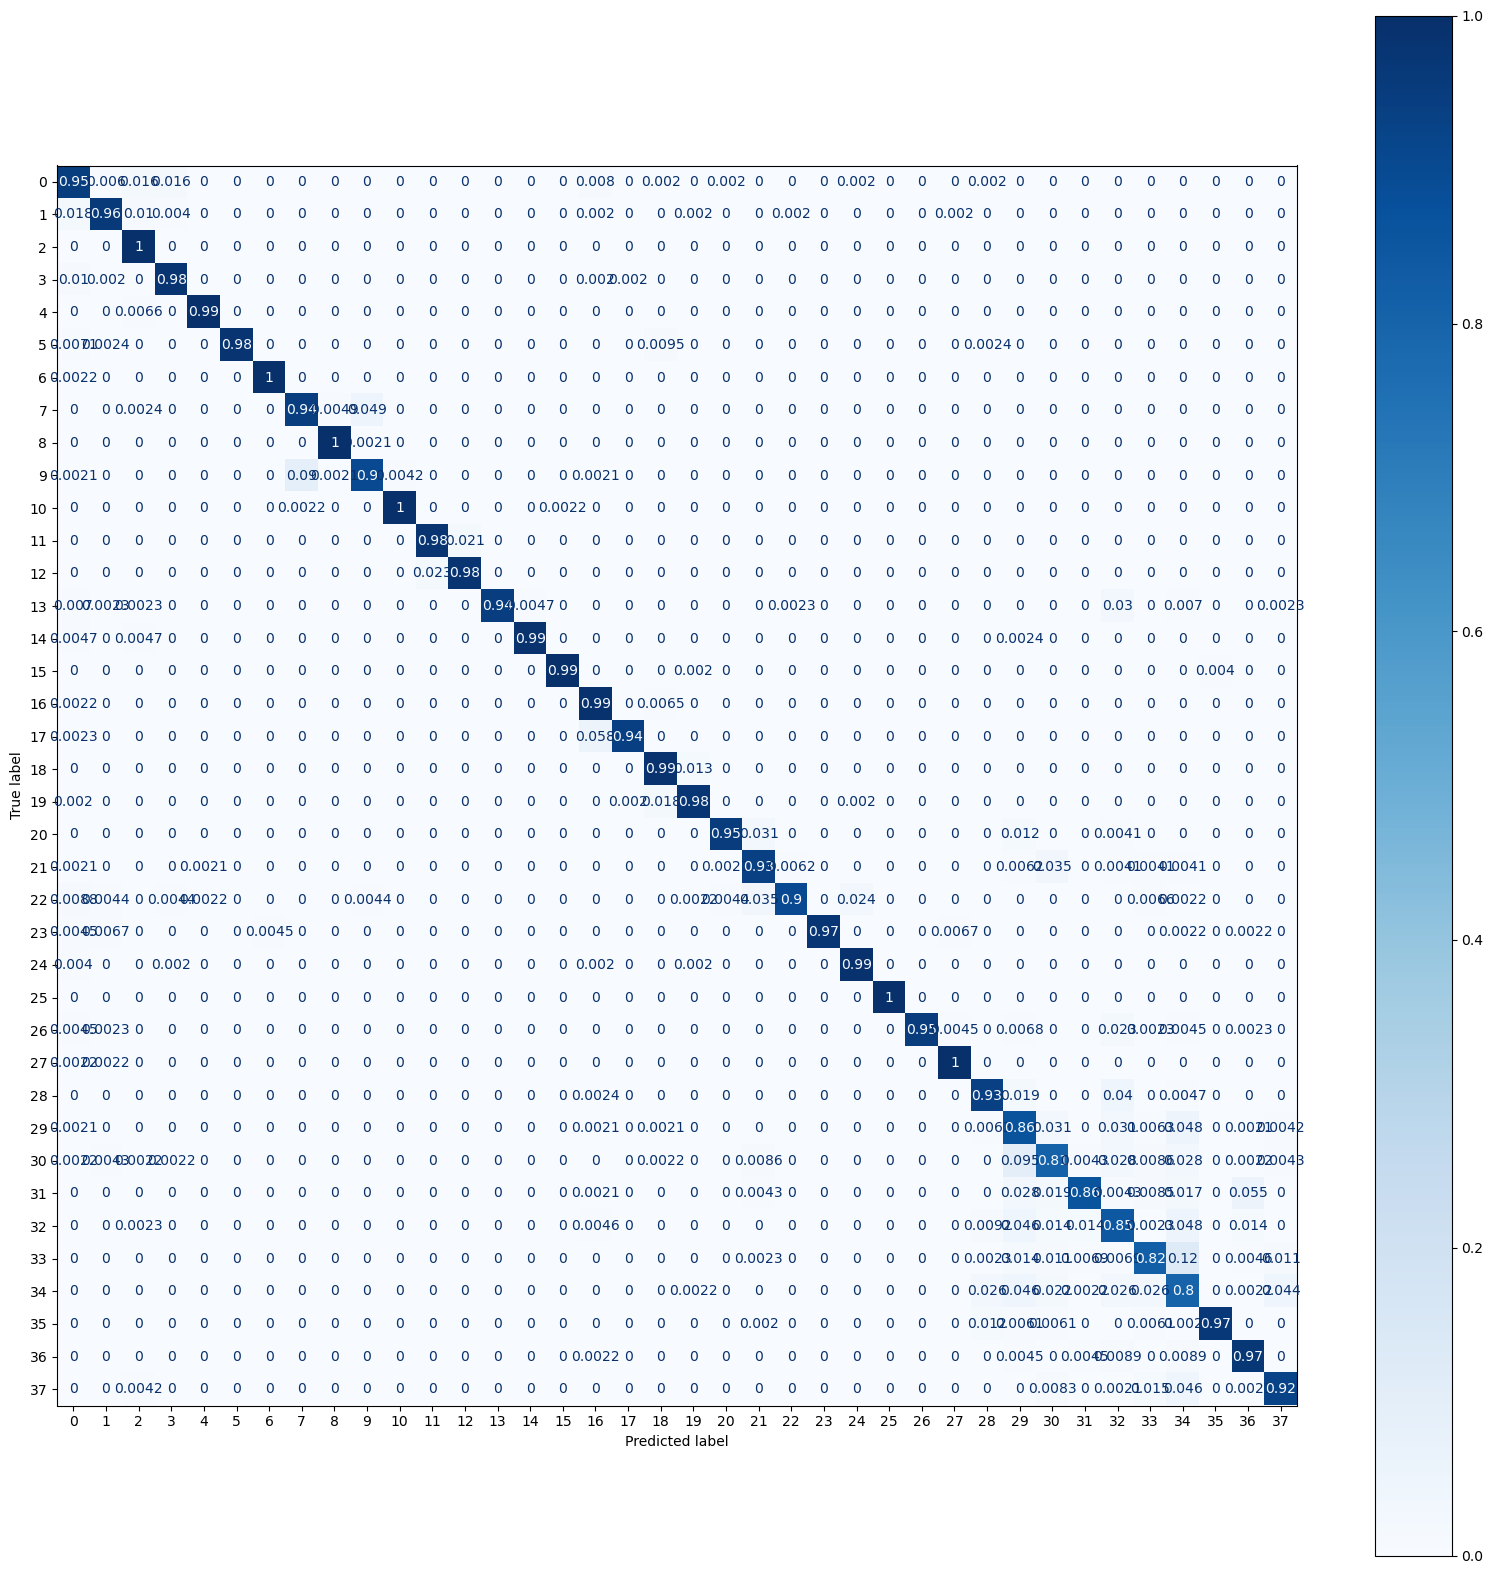

In [25]:
plot_confusion_matrix( preds )

In [17]:
callbacks = [ tfmot.sparsity.keras.UpdatePruningStep() ]
Pruner = tfmot.sparsity.keras.prune_low_magnitude

batch_size = valid_generator.batch_size
num_images = valid_generator.n
end_step = np.ceil( num_images / batch_size ).astype( np.int32 ) * 2

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.1,
        final_sparsity=0.5,
        begin_step=0,
        end_step=end_step
    ),
}

model = get_new_model()
model.load_weights( './models/model.h5' )

optimizer = keras.optimizers.legacy.Adam( learning_rate = learning_rate )
model.layers[ -2 ].rate = dropout

pruned_model = Pruner( model, **pruning_params )

pruned_model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = [ 'accuracy' ]
)

step_size_train = train_generator.n // train_generator.batch_size
pruned_model.fit(
    train_generator,
    steps_per_epoch = step_size_train,
    validation_data = valid_generator,
    epochs = 2,
    callbacks = callbacks
)

# pruned_model.summary()

Epoch 1/2
593/593 [==============================] - 340s 563ms/step - loss: 0.2298 - accuracy: 0.9477 - val_loss: 0.3048 - val_accuracy: 0.9465
Epoch 2/2
593/593 [==============================] - 333s 562ms/step - loss: 0.2950 - accuracy: 0.9315 - val_loss: 0.3799 - val_accuracy: 0.9302


In [18]:
pruned_model.save( './models/pruned_model.h5' )

/opt/homebrew/anaconda3/envs/dataspell-conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
compressed_model = tfmot.sparsity.keras.strip_pruning( pruned_model )

keras.models.save_model(
    compressed_model,
    'models/compressed_model.h5',
    include_optimizer = False
)

print( compressed_model.summary() )

/var/folders/8p/3l7sfzp10l3_0w_tckpkhyhw0000gn/T/ipykernel_85339/2638058420.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [171]:
# model = keras.models.load_model( './models/model.h5' )
# pruned_model.load_weights( './models/pruned_model.h5' )
compressed_model.load_weights( './models/compressed_model.h5' )
compressed_model.compile(
    metrics = [ 'accuracy' ]
)

# _, model_acc = model.evaluate( valid_generator )
# _, pruned_model_acc = pruned_model.evaluate( valid_generator )
_, compressed_model_acc = compressed_model.evaluate( valid_generator )

# print('Original accuracy:', model_acc)
# print('Pruned accuracy:', pruned_model_acc)
print('Compressed accuracy:', compressed_model_acc)

8779/8779 [==============================] - 195s 22ms/step - loss: 0.0000e+00 - accuracy: 0.9302
Compressed accuracy: 0.9301742911338806


In [39]:
preds = get_classification_report( compressed_model )

8779/8779 [==============================] - 175s 20ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       500
           1       0.96      0.99      0.97       497
           2       0.98      0.99      0.99       440
           3       0.97      0.92      0.95       500
           4       0.96      0.99      0.98       454
           5       0.99      0.98      0.99       421
           6       1.00      1.00      1.00       456
           7       0.92      0.92      0.92       410
           8       0.98      1.00      0.99       477
           9       0.95      0.90      0.92       477
          10       1.00      1.00      1.00       465
          11       0.82      1.00      0.90       472
          12       1.00      0.79      0.88       480
          13       1.00      0.98      0.99       430
          14       1.00      0.98      0.99       423
          15       0.99      1.00      0.99       500
          16       1.

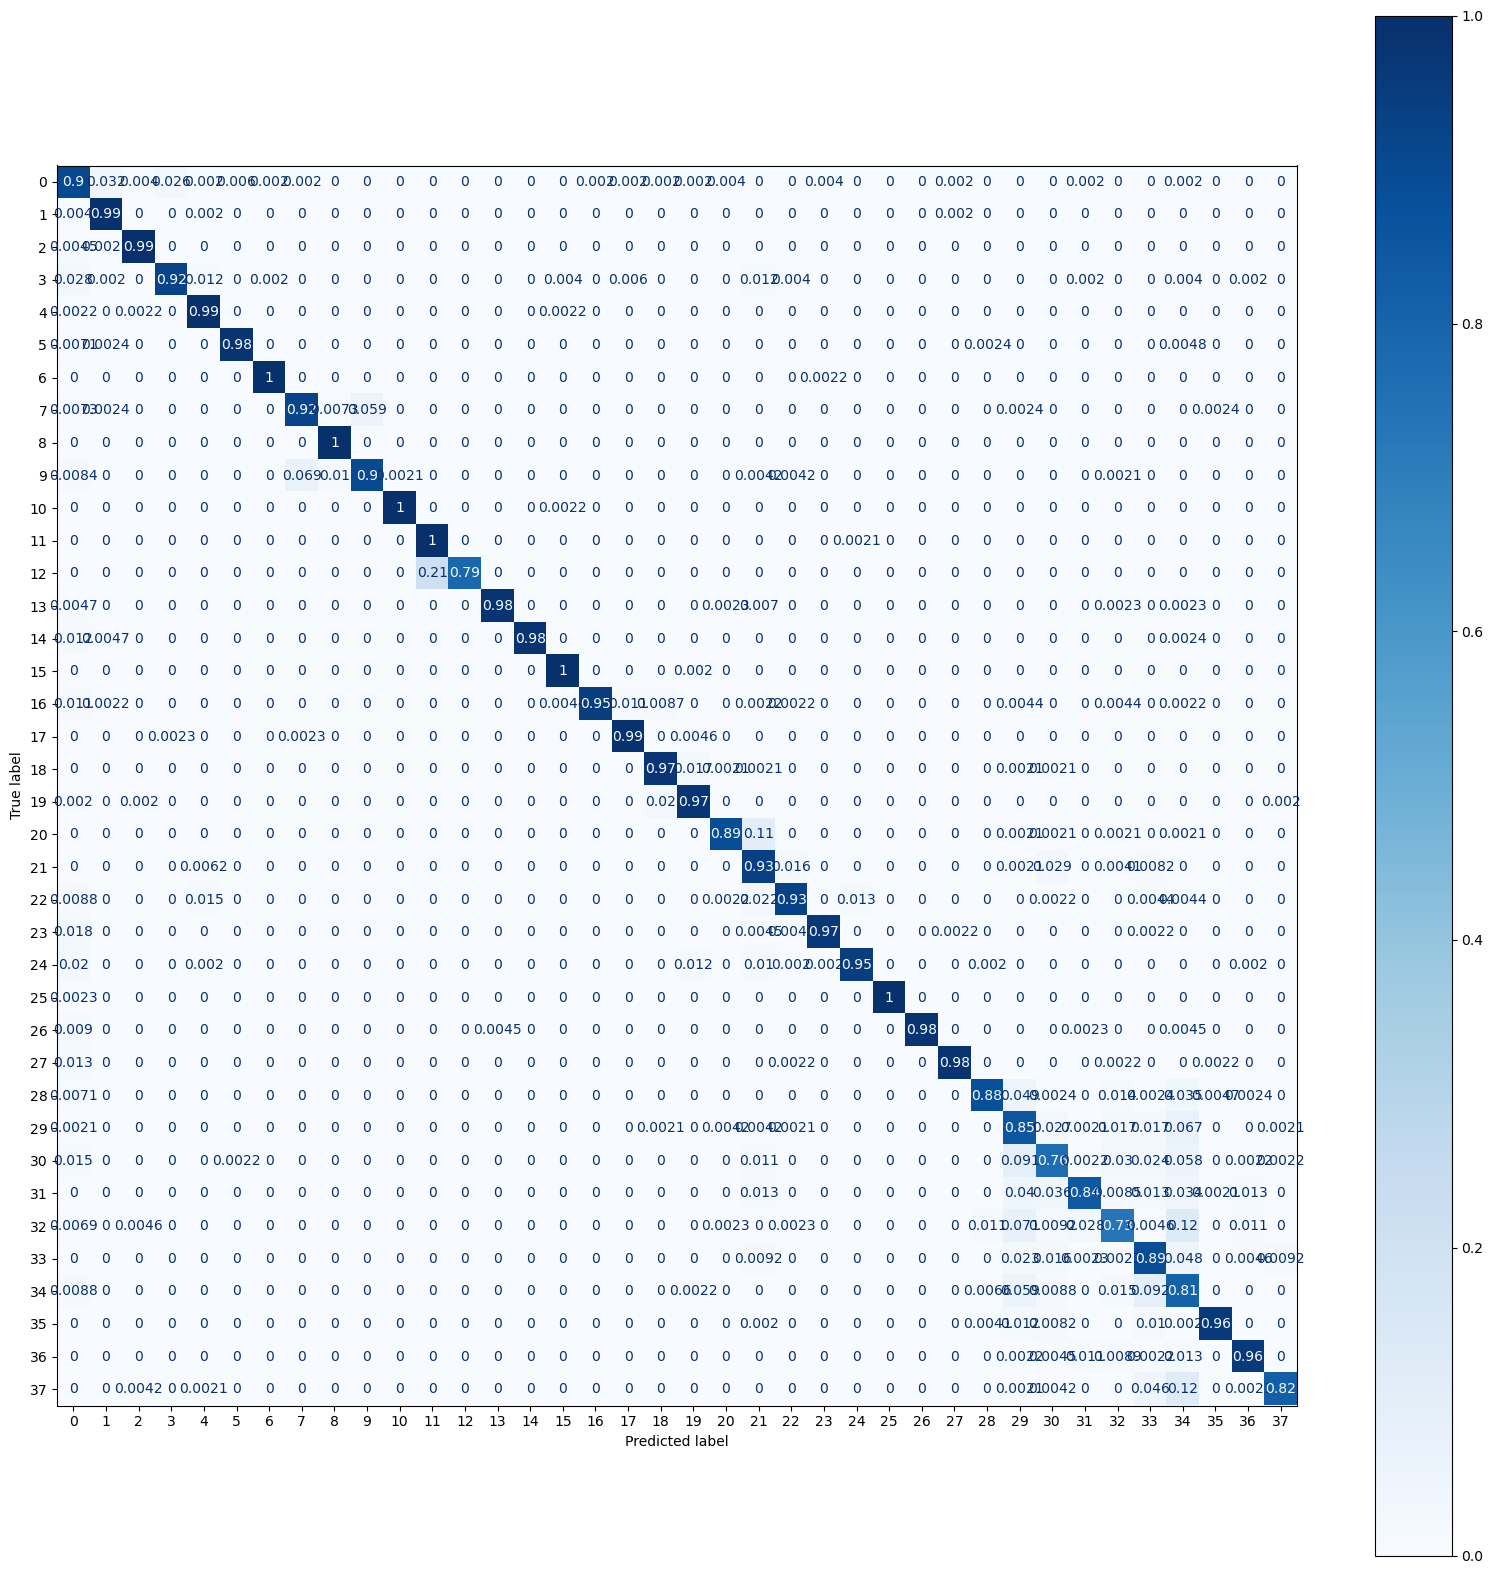

In [40]:
plot_confusion_matrix( preds )

In [41]:
labels = valid_generator.class_indices
labels = dict( ( v, k ) for k, v in labels.items() )
print( labels )

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [246]:
def test_random_img( _model ):
    label_num = random.randint( 0, len( labels ) -1 )
    
    test_dir = os.listdir( './dataset/valid/{}'.format( labels[ label_num ] ) )
    
    img_num = random.randint( 0, len( test_dir ) -1 )
    test_img = test_dir[ img_num ]

    img = cv2.imread( './dataset/valid/{}/{}'.format( labels[ label_num ], test_img ) )
    plt.imshow( img )

    img_pred = _model.predict( img[ None ] )
    img_pred = np.argmax( img_pred, axis = 1 )
    
    print('Image:     ', labels[ label_num ] )
    print('Prediction:', labels[ img_pred[ 0 ] ]  )

1/1 [==============================] - 0s 27ms/step
Image:      Apple___Apple_scab
Prediction: Apple___Apple_scab


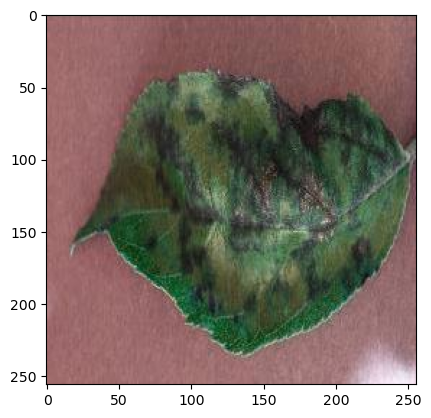

In [254]:
test_random_img( compressed_model )